# Example 3: Normalize data to MNI template

This example covers the normalization of data. Some people prefer to normalize the data during the preprocessing, just before smoothing. I prefer to do the 1st-level analysis completely in subject space and only normalize the contrasts for the 2nd-level analysis. But both approaches are fine.

For the current example, we will take the computed 1st-level contrasts from the previous experiment (again once done with fwhm=4mm and fwhm=8mm) and normalize them into MNI-space. To show two different approaches, we will do the normalization once with ANTs and once with SPM.

## Preparation

Before we can start with the ANTs example, we first need to download the already computed deformation field. The data can be found in the `derivatives/fmriprep` folder of the dataset and can be downloaded with the following `datalad` command:

In [1]:
%%bash
datalad get -J 4 -d /home/neuro/workshop/data/ds000114 /home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-0[2345789]/anat/*h5

action summary:
  get (notneeded: 8)


It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.


**Note:** This might take a while, as datalad needs to download ~710MB of data

### Alternatively: Prepare yourself
We're using the precomputed warp field from [fmriprep](http://fmriprep.readthedocs.io), as this step otherwise would take up to 10 hours or more for all subjects to complete. If you're nonetheless interested in computing the warp parameters with ANTs yourself, without using [fmriprep](http://fmriprep.readthedocs.io), either check out the script [ANTS_registration.py](https://github.com/miykael/nipype_tutorial/blob/master/notebooks/scripts/ANTS_registration.py) or even quicker, use [RegistrationSynQuick](http://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.ants/registration.html#registrationsynquick), Nipype's implementation of `antsRegistrationSynQuick.sh`.

## Normalization with ANTs

The normalization with ANTs requires that you first compute the transformation matrix that would bring the anatomical images of each subject into template space. Depending on your system this might take a few hours per subject. To facilitate this step, the transformation matrix is already computed for the T1 images.

The data for it can be found under:

In [2]:
!ls /home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-*/anat/*h5

/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-03/anat/sub-03_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-04/anat/sub-04_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-05/anat/sub-05_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-06/anat/sub-06_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-07/anat/sub-07_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-08/anat/sub-08_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-09/anat/sub-09_t1w_space-mni152nlin2

**Now, let's start with the ANTs normalization workflow!**

## Imports (ANTs)

First, we need to import all the modules we later want to use.

In [3]:
from os.path import join as opj
from nipype import Workflow, Node, MapNode
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl import Info

## Experiment parameters (ANTs)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. And remember that we decided to run the group analysis without subject ``sub-01``, ``sub-06`` and ``sub-10`` because they are left-handed (see [this section](https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html#Special-case)).

In [4]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers (remember we use only right handed subjects)
subject_list = ['02', '03', '04', '05', '07', '08', '09']

# task name
task_name = "fingerfootlips"

# Smoothing widths used during preprocessing
fwhm = [4, 8]

# Template to normalize to
template = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

**Note** if you're not using the corresponding docker image, than the **``template``** file might not be in your ``data``  directory. To get ``mni_icbm152_nlin_asym_09c``, either download it from this [website](https://files.osf.io/v1/resources/fvuh8/providers/osfstorage/580705089ad5a101f17944a9), unpack it and move it to ``/data/ds000114/derivatives/fmriprep/`` or run the following command in a cell:

```bash
%%bash
curl -L https://files.osf.io/v1/resources/fvuh8/providers/osfstorage/580705089ad5a101f17944a9 \
     -o /data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c.tar.gz
     
tar xf /data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c.tar.gz \
    -C /data/ds000114/derivatives/fmriprep/.
    
rm /data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c.tar.gz
```

## Specify Nodes (ANTs)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [5]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])

## Specify input & output stream (ANTs)

Specify where the input data can be found & where and how to save the output data.

In [6]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        'sub-{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'transform': opj('/home/neuro/workshop/data/ds000114/derivatives/fmriprep/', 'sub-{subject_id}', 'anat',
                              'sub-{subject_id}_t1w_space-mni152nlin2009casym_warp.h5')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
subjFolders += [('_apply2con%s/' % (i), '') for i in range(9)] # number of contrast used in 1stlevel an.
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (ANTs)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [7]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                             ('fwhm_id', 'fwhm_id')]),
                  (selectfiles, apply2con, [('con', 'input_image'),
                                            ('transform', 'transforms')]),
                  (apply2con, datasink, [('output_image', 'norm_ants.@con')]),
                  ])

## Visualize the workflow (ANTs)

It always helps to visualize your workflow.

211018-12:20:59,859 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/antsflow/graph.png (graph2use=colored, simple_form=True).


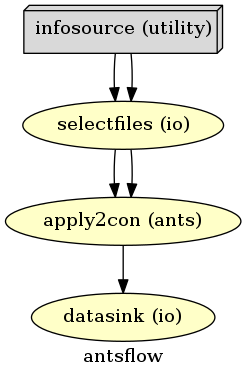

In [8]:
# Create ANTs normalization graph
antsflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(antsflow.base_dir, 'antsflow', 'graph.png'))

##  Run the Workflow (ANTs)

Now that everything is ready, we can run the ANTs normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [9]:
antsflow.run('MultiProc', plugin_args={'n_procs': 4})

211018-12:20:59,897 nipype.workflow INFO:
	 Workflow antsflow settings: ['check', 'execution', 'logging', 'monitoring']
211018-12:20:59,954 nipype.workflow INFO:
	 Running in parallel.
211018-12:20:59,958 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 14 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:21:00,16 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/output/workingdir/antsflow/_fwhm_id_8_subject_id_09/selectfiles".
211018-12:21:00,18 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/output/workingdir/antsflow/_fwhm_id_4_subject_id_09/selectfiles".
211018-12:21:00,22 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/output/workingdir/antsflow/_fwhm_id_8_subject_id_08/selectfiles".
211018-12:21:00,22 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/output/workingdir/antsflow/_fwhm_id_4_subject_id_08/selectfiles".
211018-12:21:00,26 nipype.workflow INFO:
	 [Node] Ru

211018-12:21:12,38 nipype.workflow INFO:
	 [Job 54] Cached (_apply2con3).
211018-12:21:13,984 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 114 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:21:14,49 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.datasink" in "/output/workingdir/antsflow/_fwhm_id_8_subject_id_09/datasink".
211018-12:21:14,54 nipype.workflow INFO:
	 [Job 55] Cached (_apply2con4).
211018-12:21:14,57 nipype.workflow INFO:
	 [Job 56] Cached (_apply2con5).
211018-12:21:14,56 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-12:21:14,60 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_8_subject_id_09/_apply2con0/con_0001_trans.nii -> /output/datasink/norm_ants/sub-09_fwhm8/con_0001_trans.nii
211018-12:21:14,64 nipype.workflow INFO:
	 [Job 57] Cached (_apply2con6).
211018-12:21:14,64 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_8_subject_id_09/_apply2con1/c

211018-12:21:26,172 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_8_subject_id_08/_apply2con4/con_0005_trans.nii -> /output/datasink/norm_ants/sub-08_fwhm8/con_0005_trans.nii
211018-12:21:26,175 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_8_subject_id_08/_apply2con5/con_0006_trans.nii -> /output/datasink/norm_ants/sub-08_fwhm8/con_0006_trans.nii
211018-12:21:26,177 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_8_subject_id_08/_apply2con6/con_0007_trans.nii -> /output/datasink/norm_ants/sub-08_fwhm8/con_0007_trans.nii
211018-12:21:26,179 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_8_subject_id_08/_apply2con7/ess_0008_trans.nii -> /output/datasink/norm_ants/sub-08_fwhm8/ess_0008_trans.nii
211018-12:21:26,181 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_8_subject_id_08/_apply2con8/ess_0009_trans.nii -> /output/datasink/norm_ants/sub-08_fwhm8/ess_0009_trans.nii
211018-12:21:26,187 nipyp

211018-12:21:40,91 nipype.workflow INFO:
	 [Job 98] Cached (_apply2con2).
211018-12:21:40,94 nipype.workflow INFO:
	 [Job 99] Cached (_apply2con3).
211018-12:21:40,97 nipype.workflow INFO:
	 [Job 100] Cached (_apply2con4).
211018-12:21:42,55 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 68 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:21:42,110 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.datasink" in "/output/workingdir/antsflow/_fwhm_id_4_subject_id_07/datasink".
211018-12:21:42,112 nipype.workflow INFO:
	 [Job 101] Cached (_apply2con5).
211018-12:21:42,115 nipype.workflow INFO:
	 [Job 102] Cached (_apply2con6).
211018-12:21:42,117 nipype.workflow INFO:
	 [Job 103] Cached (_apply2con7).
211018-12:21:42,117 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-12:21:42,119 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_4_subject_id_07/_apply2con0/con_0001_trans.nii -> /output/datasink/

211018-12:21:52,148 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_4_subject_id_05/_apply2con5/con_0006_trans.nii -> /output/datasink/norm_ants/sub-05_fwhm4/con_0006_trans.nii
211018-12:21:52,150 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_4_subject_id_05/_apply2con6/con_0007_trans.nii -> /output/datasink/norm_ants/sub-05_fwhm4/con_0007_trans.nii
211018-12:21:52,152 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_4_subject_id_05/_apply2con7/ess_0008_trans.nii -> /output/datasink/norm_ants/sub-05_fwhm4/ess_0008_trans.nii
211018-12:21:52,153 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_4_subject_id_05/_apply2con8/ess_0009_trans.nii -> /output/datasink/norm_ants/sub-05_fwhm4/ess_0009_trans.nii
211018-12:21:52,158 nipype.workflow INFO:
	 [Node] Finished "antsflow.datasink".
211018-12:21:54,72 nipype.workflow INFO:
	 [Job 23] Completed (antsflow.datasink).
211018-12:21:54,76 nipype.workflow INFO:
	 [MultiProc] R

211018-12:22:06,155 nipype.workflow INFO:
	 [Job 143] Cached (_apply2con2).
211018-12:22:08,94 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 25 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:22:08,139 nipype.workflow INFO:
	 [Job 31] Cached (antsflow.apply2con).
211018-12:22:08,144 nipype.workflow INFO:
	 [Job 144] Cached (_apply2con3).
211018-12:22:08,149 nipype.workflow INFO:
	 [Job 145] Cached (_apply2con4).
211018-12:22:08,157 nipype.workflow INFO:
	 [Job 146] Cached (_apply2con5).
211018-12:22:10,97 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 22 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:22:10,158 nipype.workflow INFO:
	 [Job 147] Cached (_apply2con6).
211018-12:22:10,157 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.datasink" in "/output/workingdir/antsflow/_fwhm_id_8_subject_id_03/datasink".
211018-12:22:10,162 nipype.workflow INFO:
	 [Job 148] Cached (_apply2con7).
211018-12:22:10,165 nipype.w

211018-12:22:20,203 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_8_subject_id_02/_apply2con4/con_0005_trans.nii -> /output/datasink/norm_ants/sub-02_fwhm8/con_0005_trans.nii
211018-12:22:20,204 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_8_subject_id_02/_apply2con5/con_0006_trans.nii -> /output/datasink/norm_ants/sub-02_fwhm8/con_0006_trans.nii
211018-12:22:20,206 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_8_subject_id_02/_apply2con6/con_0007_trans.nii -> /output/datasink/norm_ants/sub-02_fwhm8/con_0007_trans.nii
211018-12:22:20,207 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_8_subject_id_02/_apply2con7/ess_0008_trans.nii -> /output/datasink/norm_ants/sub-02_fwhm8/ess_0008_trans.nii
211018-12:22:20,208 nipype.interface INFO:
	 sub: /output/datasink/norm_ants/_fwhm_id_8_subject_id_02/_apply2con8/ess_0009_trans.nii -> /output/datasink/norm_ants/sub-02_fwhm8/ess_0009_trans.nii
211018-12:22:20,213 nipyp

# Normalization with SPM12

The normalization with SPM12 is rather straightforward. The only thing we need to do is run the Normalize12 module. **So let's start!**

## Imports (SPM12)

First, we need to import all the modules we later want to use.

In [10]:
from os.path import join as opj
from nipype.interfaces.spm import Normalize12
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype import Workflow, Node

## Experiment parameters (SPM12)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. And remember that we decided to run the group analysis without subject ``sub-01``, ``sub-06`` and ``sub-10`` because they are left-handed (see [this section](https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html#Special-case)).

In [11]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['02', '03', '04', '05', '07', '08', '09']

# task name
task_name = "fingerfootlips"

# Smoothing withds used during preprocessing
fwhm = [4, 8]

template = '/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'

## Specify Nodes (SPM12)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [12]:
# Gunzip - unzip the anatomical image
gunzip = Node(Gunzip(), name="gunzip")

# Normalize - normalizes functional and structural images to the MNI template
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[1, 1, 1]),
                 name="normalize")

## Specify input & output stream (SPM12)

Specify where the input data can be found & where and how to save the output data.

In [13]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        'sub-{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'anat': opj('/home/neuro/workshop/data/ds000114/derivatives', 'fmriprep', 'sub-{subject_id}',
                         'anat', 'sub-{subject_id}_t1w_preproc.nii.gz')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (SPM12)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [14]:
# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir, working_dir)

# Connect up SPM normalization components
spmflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('fwhm_id', 'fwhm_id')]),
                 (selectfiles, normalize, [('con', 'apply_to_files')]),
                 (selectfiles, gunzip, [('anat', 'in_file')]),
                 (gunzip, normalize, [('out_file', 'image_to_align')]),
                 (normalize, datasink, [('normalized_files', 'norm_spm.@files'),
                                        ('normalized_image', 'norm_spm.@image'),
                                        ]),
                 ])

## Visualize the workflow (SPM12)

It always helps to visualize your workflow.

211018-12:22:30,470 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/spmflow/graph.png (graph2use=colored, simple_form=True).


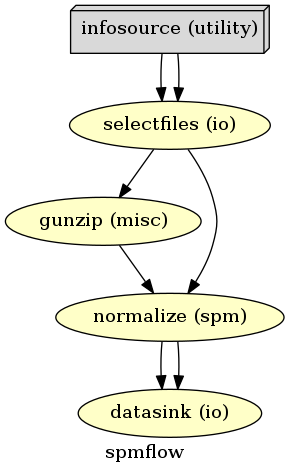

In [15]:
# Create SPM normalization graph
spmflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(spmflow.base_dir, 'spmflow', 'graph.png'))

##  Run the Workflow (SPM12)

Now that everything is ready, we can run the SPM normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [16]:
spmflow.run('MultiProc', plugin_args={'n_procs': 4})

211018-12:22:30,485 nipype.workflow INFO:
	 Workflow spmflow settings: ['check', 'execution', 'logging', 'monitoring']
211018-12:22:30,537 nipype.workflow INFO:
	 Running in parallel.
211018-12:22:30,541 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 14 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-12:22:30,606 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/output/workingdir/spmflow/_fwhm_id_8_subject_id_09/selectfiles".
211018-12:22:30,608 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/output/workingdir/spmflow/_fwhm_id_4_subject_id_09/selectfiles".
211018-12:22:30,612 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/output/workingdir/spmflow/_fwhm_id_4_subject_id_08/selectfiles".
211018-12:22:30,612 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/output/workingdir/spmflow/_fwhm_id_8_subject_id_08/selectfiles".
211018-12:22:30,617 nipype.workflow INFO:
	 [Node] Runnin

211018-12:22:36,706 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_8_subject_id_08/wcon_0006.nii -> /output/datasink/norm_spm/sub-08_fwhm8/wcon_0006.nii
211018-12:22:36,742 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_8_subject_id_08/wcon_0007.nii -> /output/datasink/norm_spm/sub-08_fwhm8/wcon_0007.nii
211018-12:22:36,743 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-12:22:36,744 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_8_subject_id_08/wess_0008.nii -> /output/datasink/norm_spm/sub-08_fwhm8/wess_0008.nii
211018-12:22:36,746 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_8_subject_id_08/wess_0009.nii -> /output/datasink/norm_spm/sub-08_fwhm8/wess_0009.nii
211018-12:22:36,746 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_4_subject_id_08/wcon_0001.nii -> /output/datasink/norm_spm/sub-08_fwhm4/wcon_0001.nii
211018-12:22:36,748 nipype.interface INFO

211018-12:22:44,662 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_4_subject_id_07/wcon_0003.nii -> /output/datasink/norm_spm/sub-07_fwhm4/wcon_0003.nii
211018-12:22:44,662 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_8_subject_id_07/wsub-07_t1w_preproc.nii -> /output/datasink/norm_spm/sub-07_fwhm8/wsub-07_t1w_preproc.nii
211018-12:22:44,664 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_4_subject_id_07/wcon_0004.nii -> /output/datasink/norm_spm/sub-07_fwhm4/wcon_0004.nii
211018-12:22:44,666 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_4_subject_id_07/wcon_0005.nii -> /output/datasink/norm_spm/sub-07_fwhm4/wcon_0005.nii
211018-12:22:44,668 nipype.workflow INFO:
	 [Node] Finished "spmflow.datasink".
211018-12:22:44,668 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_4_subject_id_07/wcon_0006.nii -> /output/datasink/norm_spm/sub-07_fwhm4/wcon_0006.nii
211018-12:22:44,670 nipype.interface INFO:
	 

211018-12:22:48,631 nipype.workflow INFO:
	 [Job 33] Cached (spmflow.gunzip).
211018-12:22:48,636 nipype.workflow INFO:
	 [Job 37] Cached (spmflow.gunzip).
211018-12:22:48,640 nipype.workflow INFO:
	 [Job 41] Cached (spmflow.gunzip).
211018-12:22:48,645 nipype.workflow INFO:
	 [Job 45] Cached (spmflow.gunzip).
211018-12:22:50,626 nipype.workflow INFO:
	 [Job 34] Cached (spmflow.normalize).
211018-12:22:50,632 nipype.workflow INFO:
	 [Job 38] Cached (spmflow.normalize).
211018-12:22:50,640 nipype.workflow INFO:
	 [Job 42] Cached (spmflow.normalize).
211018-12:22:50,646 nipype.workflow INFO:
	 [Job 46] Cached (spmflow.normalize).
211018-12:22:52,644 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/output/workingdir/spmflow/_fwhm_id_8_subject_id_04/datasink".
211018-12:22:52,650 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-12:22:52,652 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_8_subject_id_04/wcon_0001.n

211018-12:22:52,740 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_4_subject_id_03/wess_0008.nii -> /output/datasink/norm_spm/sub-03_fwhm4/wess_0008.nii
211018-12:22:52,743 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_4_subject_id_03/wess_0009.nii -> /output/datasink/norm_spm/sub-03_fwhm4/wess_0009.nii
211018-12:22:52,745 nipype.interface INFO:
	 sub: /output/datasink/norm_spm/_fwhm_id_4_subject_id_03/wsub-03_t1w_preproc.nii -> /output/datasink/norm_spm/sub-03_fwhm4/wsub-03_t1w_preproc.nii
211018-12:22:52,757 nipype.workflow INFO:
	 [Node] Finished "spmflow.datasink".
211018-12:22:54,585 nipype.workflow INFO:
	 [Job 35] Completed (spmflow.datasink).
211018-12:22:54,586 nipype.workflow INFO:
	 [Job 39] Completed (spmflow.datasink).
211018-12:22:54,589 nipype.workflow INFO:
	 [Job 43] Completed (spmflow.datasink).
211018-12:22:54,590 nipype.workflow INFO:
	 [Job 47] Completed (spmflow.datasink).
211018-12:22:54,593 nipype.workflow INFO:
	 [MultiProc]

# Comparison between ANTs and SPM normalization

Now that we ran the normalization with ANTs and SPM, let us compare their output.

In [17]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
anatimg = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

First, let's compare the normalization of the **anatomical** images:

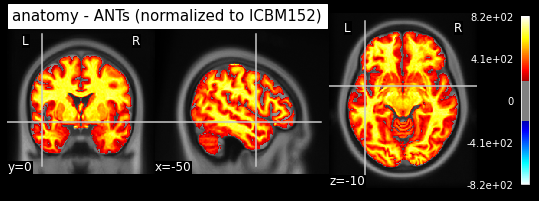

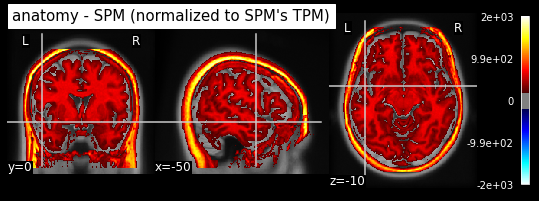

In [19]:
plot_stat_map(
    '/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_space-mni152nlin2009casym_preproc.nii.gz',
    title='anatomy - ANTs (normalized to ICBM152)', bg_img=anatimg,
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10));
plot_stat_map(
    '/output/datasink/norm_spm/sub-02_fwhm4/wsub-02_t1w_preproc.nii',
    title='anatomy - SPM (normalized to SPM\'s TPM)', bg_img=anatimg,
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10));

And what about the **contrast** images for **Finger > others**?

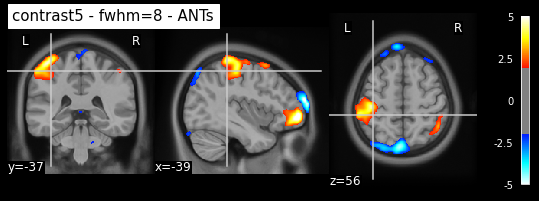

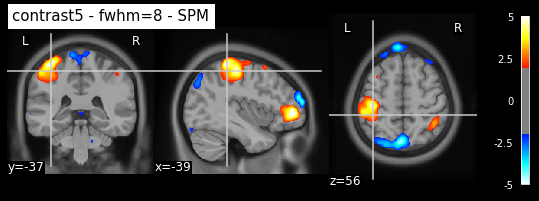

In [20]:
plot_stat_map(
    '/output/datasink/norm_ants/sub-02_fwhm8/con_0005_trans.nii', title='contrast5 - fwhm=8 - ANTs',
    bg_img=anatimg, threshold=2, vmax=5, display_mode='ortho', cut_coords=(-39, -37, 56));
plot_stat_map(
    '/output/datasink/norm_spm/sub-02_fwhm8/wcon_0005.nii', title='contrast5 - fwhm=8 - SPM',
    bg_img=anatimg, threshold=2, vmax=5, display_mode='ortho', cut_coords=(-39, -37, 56));

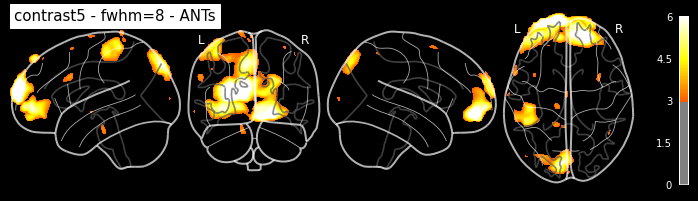

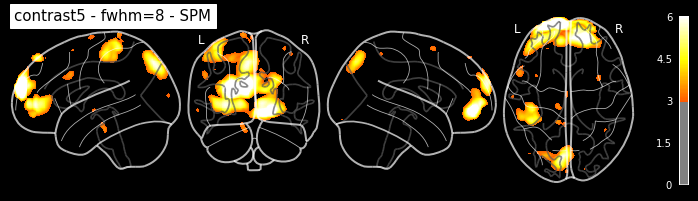

In [21]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/output/datasink/norm_ants/sub-02_fwhm8/con_0005_trans.nii', colorbar=True,
    threshold=3, display_mode='lyrz', black_bg=True, vmax=6, title='contrast5 - fwhm=8 - ANTs')
plot_glass_brain(
    '/output/datasink/norm_spm/sub-02_fwhm8/wcon_0005.nii', colorbar=True,
    threshold=3, display_mode='lyrz', black_bg=True, vmax=6, title='contrast5 - fwhm=8 - SPM');